## Appendix

The eczema medical trial data set again. This time we will compare which of 2 models explain the observed data best.

* Model 1: All studies have the same probability of success.
* Model 2: A hierarchical model where the probability of success in each study is drawn from a beta prior distribution with unknown $\alpha$ and $\beta$ parameters.


|Study          | Treatment group |   Control group  |
|---------------|-----------------|------------------|
|Di Rienzo 2014 |     20 / 23     |        9 / 15    |
|Galli 1994     |     10 / 16     |       11 / 18    |
|Kaufman 1974   |     13 / 16     |        4 / 10    |
|Qin 2014       |     35 / 45     |       21 / 39    |
|Sanchez 2012   |     22 / 31     |       12 / 29    |
|Silny 2006     |      7 / 10     |        0 / 10    |
|**Totals**     |    107 / 141    |       57 / 121   |


**Model 1:**

* For each group (treatment and control), all 6 studies have the same fixed, but unknown, probability of success, $\theta_t,\theta_c\in[0,1]$.
* The data follow a binomial distribution in each study, conditioned on the probability of success — $\theta_t$ for treatment or $\theta_c$ for control.
* The priors over $\theta_t$ and $\theta_c$ are uniform.

These assumptions lead to the following model.

* Likelihood: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients.

* Prior: $\text{Beta}(\theta\,|\,1,1)$ for both $\theta_t$ and $\theta_c$.

* Posterior for treatment group: $\text{Beta}(\theta_t\,|\,108, 35)$.

* Posterior for control group: $\text{Beta}(\theta_c\,|\,58, 65)$.

Since we have closed-form solutions for the posteriors, we can calculate the marginal likelihood by rearranging Bayes' equation: (marginal likelihood) = (likelihood) x (prior) / (posterior).

$$ P(\text{data}) = \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i) \right] \text{Beta}(\theta\,|\,\alpha_0,\beta_0) \,/\, \text{Beta}(\theta\,|\,\alpha_1,\beta_1)$$
where $\alpha_0=1$ and $\beta_0=1$ are the parameters of the prior, and $\alpha_1$ and $\beta_1$ are the parameters of the posterior beta distribution.

Since all factors involving $\theta$ cancel out, we are just left with the normalization constants of the likelihood, the prior and the posterior:

$$\begin{aligned}
P(\text{data})
&= \left[ \prod_{i=1}^6 \left(\begin{array}{c}s_i+f_i \\ s_i\end{array}\right) \right] \frac{\text{B}(\alpha_1,\beta_1)}{\text{B}(\alpha_0,\beta_0)} \\
&= \left[\prod_{i=1}^6 \frac{1}{(s_i+f_i+1)\text{B}(s_i+1,f_i+1)}\right] \frac{\text{B}(\alpha_1,\beta_1)}{\text{B}(\alpha_0,\beta_0)}
\end{aligned}$$

We usually compute the log of the marginal likelihood since the results can vary over many orders of magnitude.

**A word on notation** in the derivation above:

* The beta _distribution_ is written as $\text{Beta}(\theta \,|\, \alpha, \beta)$.
* The beta _function_ is written as $B(\alpha,\beta)$. $B$ is the Greek letter _capital beta_.
* The beta function is part of the normalization constant of the beta distribution.

This is similar to the gamma distribution and the gamma function, where

* the distribution is written as $\text{Gamma}(x \,|\, \alpha, \beta)$,
* the function is written as $\Gamma(\alpha)$,
* the gamma function is part of the normalization constant of the gamma distribution.

**A word on simplifying the expression** in the derivation above:

Just as the gamma function is related to factorials, the beta function is related to combinations:

* $n! = \Gamma(n+1)$ for integer $n$.
* $\binom{n}{k}=\left((n+1)\cdot B(n-k+1, k+1)\right)^{-1}$

The beta function can also be written in terms of the gamma function:

* $B(x,y) = \Gamma(x)\ \Gamma(y)\ /\ \Gamma(x+y)$


## Task 1

1. Take the log of the marginal likelihood above.
2. Complete the Python function below to calculate the log marginal likelihood.
3. You can use the built-in function `scipy.special.betaln(a,b)` to compute $\log \text{B}(a,b)$.

**Model 2:**

* For each group (intervention and control), each of the 6 studies has a different probability of success.
* Each probability of success is drawn from a beta prior with unknown parameters $\alpha$ and $\beta$.
* Since $\alpha$ and $\beta$ are unknown, we put a broad hyperprior on them — we choose the Gamma(2, 0.5) distribution, which is shown below.

These assumptions lead to the following model:

* Likelihood: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients. Note that each study has its own $\theta_i$, whereas Model 1 had the same $\theta$ for all 6 studies.

* Prior: $\prod_{i=1}^6 \text{Beta}(\theta_i\,|\,\alpha,\beta)$.

* Hyperprior: $P(\alpha,\beta) = \text{Gamma}(\alpha\,|\,2,0.5)\,\text{Gamma}(\beta\,|\,2,0.5)$.

This model has 8 parameters (for each of the treatment and control groups), namely $\theta_1, \ldots, \theta_6$, $\alpha$, and $\beta$.

Since the posterior does not have a closed-form analytical solution, we have to calculate the marginal likelihood by integrating out all of the parameters in the model.

$$ P(\text{data}) = \int_0^{\infty} \int_0^{\infty} \int_0^1\cdots\int_0^1 \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta) \right] P(\alpha,\beta)\ \text{d}\theta_6\cdots\text{d}\theta_1\,\text{d}\beta\,\text{d}\alpha$$

This looks like a crazy 8-dimensional integral, but we can actually integrate out the $\theta_i$ analytically, leaving a 2-dimensional integral over $\alpha$ and $\beta$.

First, note that $P(\alpha,\beta)$ does not contain $\theta_i$, so we can move it outside of the $\theta_i$ integrals.

$$ = \int_0^{\infty} \int_0^{\infty} P(\alpha,\beta) {\color{blue}{\int_0^1\cdots\int_0^1 \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta) \right] \ \text{d}\theta_6\cdots\text{d}\theta_1}}\,\text{d}\beta\,\text{d}\alpha$$

Next, since there are no factors containing two different $\theta_i$ variables, we can rearrange the integrals and the products (the blue part) like this:

$$ = \int_0^{\infty} \int_0^{\infty} P(\alpha,\beta) {\color{blue}{\left[\prod_{i=1}^6 \int_0^1\text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta)\,\text{d}\theta_i\right]}}\,\text{d}\beta\,\text{d}\alpha$$

**Note that we cannot always swap products and integrals.**


Since the beta distribution is conjugate to the binomial, the blue integrals above can be evaluated analytically (much like we did for Model 1), to get

$$ = \int_0^{\infty}\int_0^{\infty} P(\alpha,\beta) \left[\prod_{i=1}^6 \frac{1}{(s_i+f_i+1)\,\text{B}(s_i+1,f_i+1)}\,\frac{\text{B}(\alpha+s_i, \beta+f_i)}{\text{B}(\alpha,\beta)}\right]\,\text{d}\beta\,\text{d}\alpha$$

Finally, move all the factors that do not depend on $\alpha$ or $\beta$ out of the integrals.

$$ = \left[\prod_{i=1}^6 (s_i+f_i+1)\,\text{B}(s_i+1,f_i+1) \right]^{-1} \int_0^{\infty}\int_0^{\infty} P(\alpha,\beta)\, \text{B}(\alpha,\beta)^{-6} \prod_{i=1}^6 \text{B}(\alpha+s_i, \beta+f_i)\ \text{d}\beta\,\text{d}\alpha$$

Unfortunately we cannot evaluate the remaining integrals analytically, so we resort to a numerical calculation.

In [1]:
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data
data_treatment = np.array([
    [20, 10, 13, 35, 22, 7],  # Sucesses
    [3, 6, 3, 10, 9, 3]       # Failures
])

data_control = np.array([
    [9, 11, 4, 21, 12, 0],    # Sucesses
    [6, 7, 6, 18, 17, 10]     # Failures
])

In [3]:
def gen_samples(a:int, b:int, sample_size:int=10_000, orig_data=data_control):
    totals: np.array = orig_data[0]+orig_data[1]
    
    # Generate posterior probabilities of success
    model = beta(a, b)
    p_samples: np.array = model.rvs(size=sample_size)
        
    # Generate the data based on the theta values calculated
    samples = binom.rvs(totals, p_samples.reshape(-1, 1))
    return samples

In [4]:
def test_plot(
    a: int, b: int, orig_data: np.array = data_control, 
    sample_size:int=10_000, func=np.std
):
    """
    Generates a plot of when a test statistic is applied on generated data from
    the model
    
    :param orig_data: The original data that provides the total points per study
    :param func: The test statistic function to apply
    """
    samples: np.array = gen_samples(a=a, b=b, sample_size=sample_size, orig_data=orig_data)
    totals: np.array = orig_data[0] + orig_data[1]
    test_statistic_data: np.array = func(samples/totals, axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.hist(test_statistic_data, alpha=0.5, bins=100)
    original_test_statistic = func(orig_data[0]/totals)
    plt.axvline(original_test_statistic, color='red', label="Orginal Test statistic")
    plt.xlabel(f'Test statistic of success rate [{func.__name__}]')
    plt.title(
        f'Test statistic distribution of model generated data (p-value = {np.mean(test_statistic_data>original_test_statistic)})'
    )
    plt.legend()

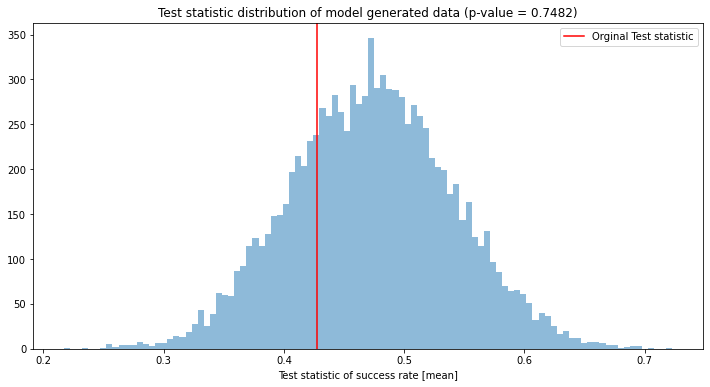

In [5]:
test_plot(58, 65, func=np.mean)

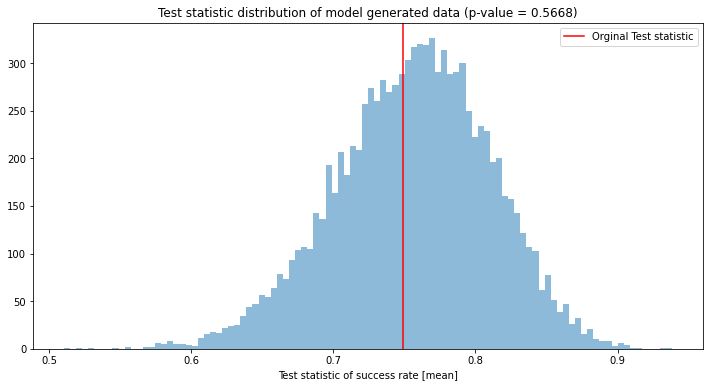

In [6]:
test_plot(108, 35, orig_data=data_treatment,func=np.mean)

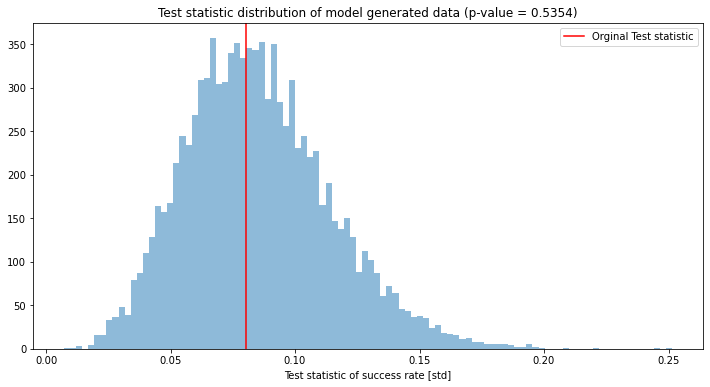

In [7]:
test_plot(108, 35, orig_data=data_treatment)